In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
from collections import Counter

from sklearn.linear_model import Lasso, LassoCV

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_prices = pd.read_csv('top100cap_stock_prices.csv',parse_dates=['Date'],index_col='Date')
dates_list = ['2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01', 
              '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01', 
              '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', 
              '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01' ]
df_prices.head()

AAPL        MSFT       GOOG       AMZN       BRK-B  \
Date                                                                  
2019-01-02  39.480000  101.120003  52.292500  76.956497  202.800003   
2019-01-03  35.547501   97.400002  50.803001  75.014000  191.660004   
2019-01-04  37.064999  101.930000  53.535500  78.769501  195.199997   
2019-01-07  36.982498  102.059998  53.419498  81.475502  196.910004   
2019-01-08  37.687500  102.800003  53.813999  82.829002  196.309998   

                 TSLA         UNH         JNJ           V        XOM  ...  \
Date                                                                  ...   
2019-01-02  20.674667  243.490005  127.750000  132.919998  69.690002  ...   
2019-01-03  20.024000  236.850006  125.720001  128.130005  68.620003  ...   
2019-01-04  21.179333  239.619995  127.830002  133.649994  71.150002  ...   
2019-01-07  22.330667  240.080002  127.010002  136.059998  71.519997  ...   
2019-01-08  22.356667  243.289993  129.960007  136.800003  72.040001  ...   

                    GS        HDB         ELV         TD    3968.HK  \
Date                                                                  
2019-01-02  172.029999  51.834999  255.020004  50.259998  27.700001   
2019-01-03  169.509995  50.910000  248.419998  49.970001  27.600000   
2019-01-04  175.050003  51.790001  249.910004  50.759998  28.250000   
2019-01-07  176.020004  51.525002  250.350006  50.910000  28.650000   
2019-01-08  175.369995  51.904999  249.460007  51.110001  28.549999   

            601988.SS     CBA.AX         CAT       HSBC       INTC  
Date                                                                
2019-01-02       3.54  70.970001  126.379997  40.880001  47.080002  
2019-01-03       3.55  71.839996  121.510002  40.430000  44.490002  
2019-01-04       3.58  71.889999  128.149994  41.610001  47.220001  
2019-01-07       3.57  72.570000  128.229996  41.049999  47.439999  
2019-01-08       3.54  72.470001  129.770004  41.160000  47.740002  

[5 rows x 100 columns]

Features selected by Lasso Regressor:

005930.KS
600519.SS
BABA
RMS.PA
ADBE
CDI.PA
3690.HK
Number of features selected: 7


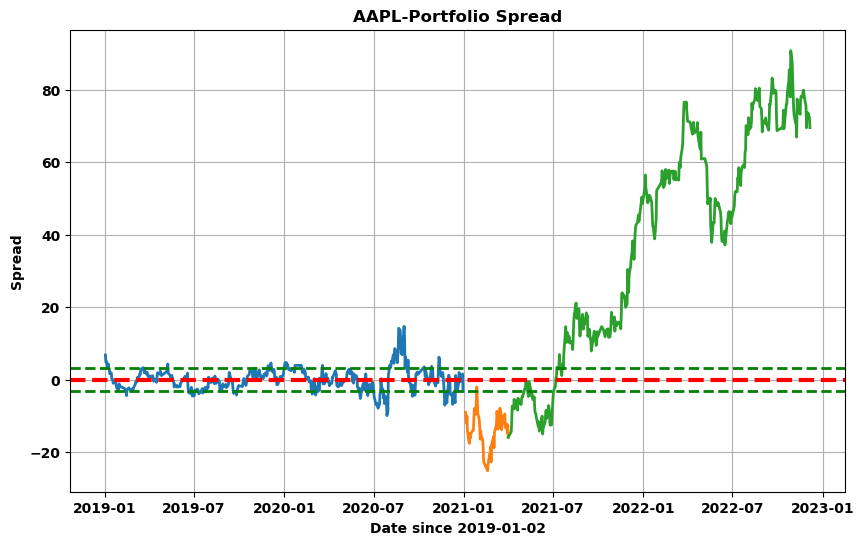

Features selected by Lasso Regressor:

005930.KS
Number of features selected: 1


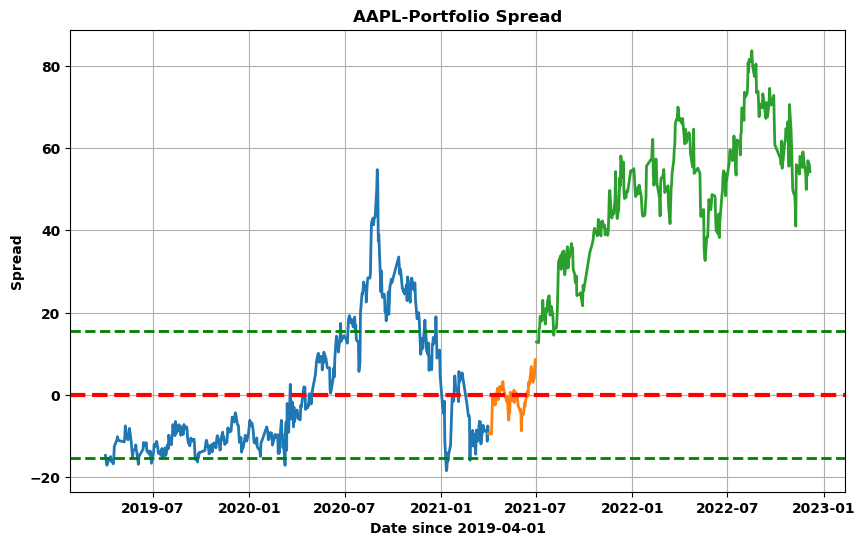

Features selected by Lasso Regressor:

005930.KS
600519.SS
BABA
TMO
RMS.PA
ADBE
CDI.PA
3690.HK
Number of features selected: 8


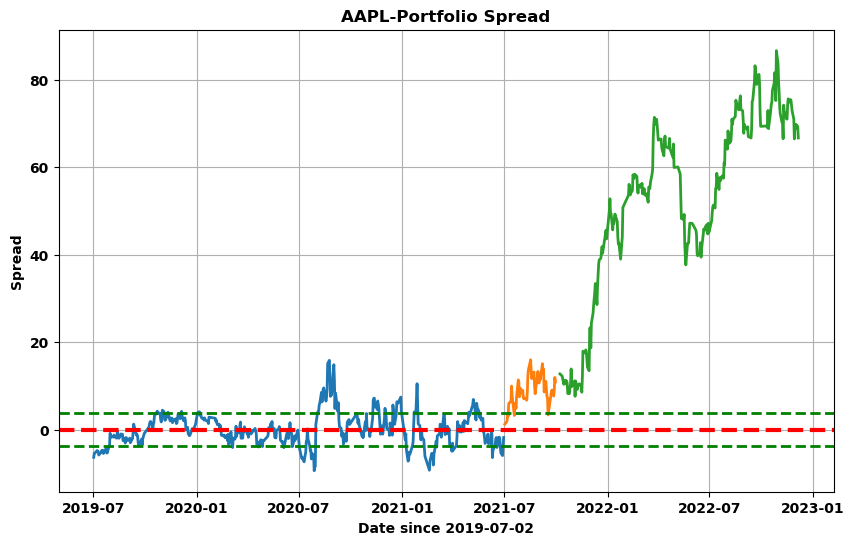

Features selected by Lasso Regressor:

005930.KS
600519.SS
TMO
RMS.PA
ADBE
3690.HK
Number of features selected: 6


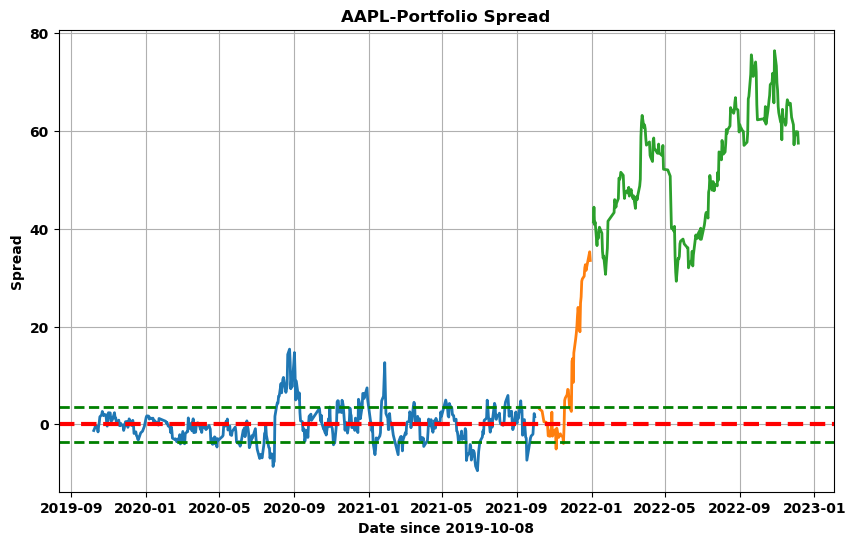

Features selected by Lasso Regressor:

005930.KS
600519.SS
TMO
RMS.PA
ADBE
Number of features selected: 5


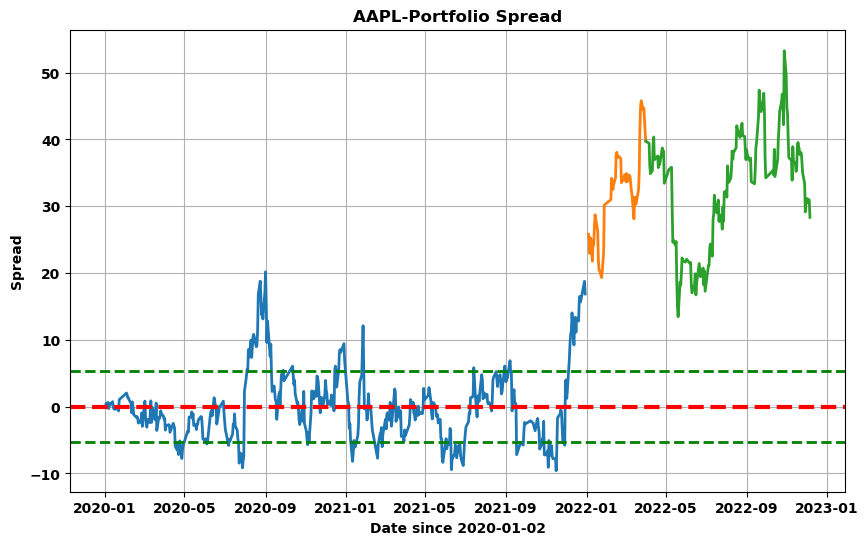

Features selected by Lasso Regressor:

MA
005930.KS
600519.SS
ASML
TMO
AVGO
COST
RMS.PA
ADBE
NFLX
CDI.PA
Number of features selected: 11


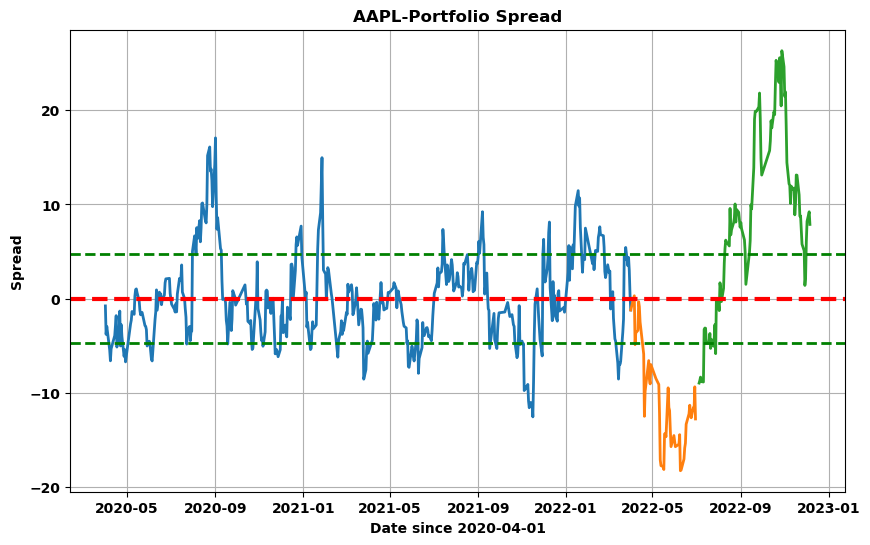

Features selected by Lasso Regressor:

005930.KS
600519.SS
AVGO
COST
ADBE
300750.SZ
Number of features selected: 6


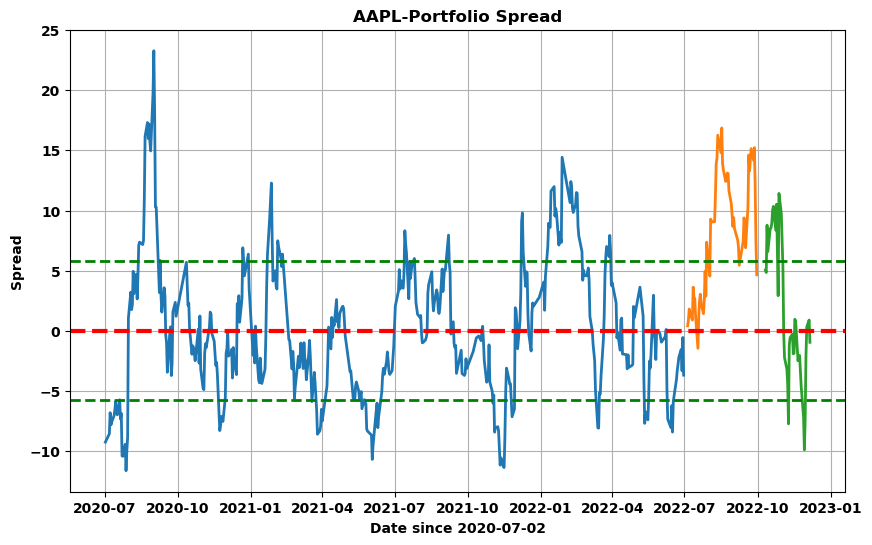

Features selected by Lasso Regressor:

005930.KS
AVGO
COST
RMS.PA
NFLX
Number of features selected: 5


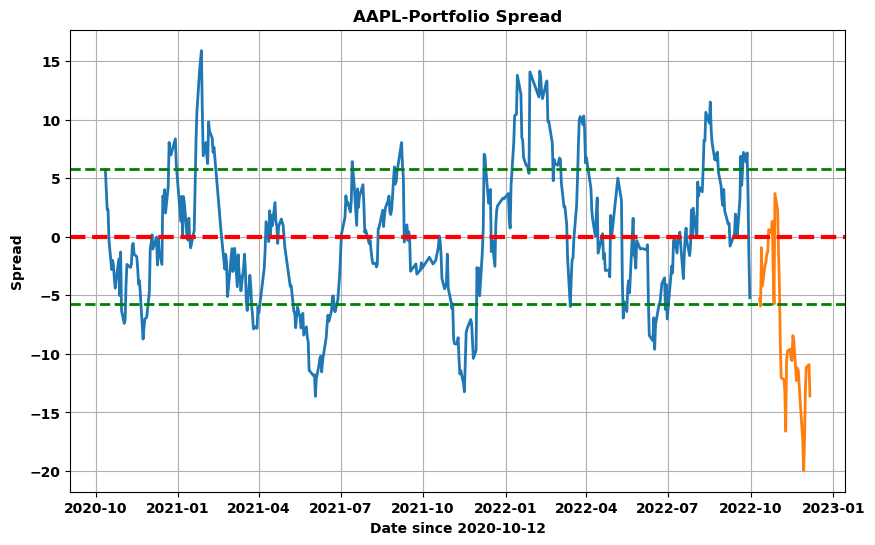

In [3]:
#each list corresponds to data for each OoS period
beta_list = [] #betas for use in analysis later on (for each OoS period)
features_selected_list = []
intercept_list = [] #intercept/beto-naught B0
train_spread_std_list = [] #standard deviation of spread from training data
train_normalized_spread_ceil_list = [] #to determine what ratio of portfolio to invest and what to hold in cash-heavy assets later on

for i in range(len(dates_list)-9): #12 months in-sample data, 3 months out-of-sample
    
    train_data = df_prices[dates_list[i]:dates_list[i+8]] #in-sample data
    test_data = df_prices[dates_list[i+8]:dates_list[i+9]] #out-of-sample data
    
    X_train = train_data.drop(['AAPL'],axis=1)
    y_train = train_data[['AAPL']]
    X_test = test_data.drop(['AAPL'],axis=1)
    y_test = test_data[['AAPL']]
    
    #first approximate nearest regularization power
    lasso_m = LassoCV(eps=1e-3, n_alphas=1000, cv=5).fit(X_train, y_train.values.ravel())
    #this tends to overtrain the (in my opinion based on training plots already overtrained) model
    #used to hone in on the best parameter value for regularization penalty
    reg_alpha = np.ceil(math.log10(lasso_m.alpha_))
    lambdas = np.arange(lasso_m.alpha_*1e-1, lasso_m.alpha_*1e1, lasso_m.alpha_*1e-2) #testing for all lambdas in the range [1e-5,1e-3] with a 1e-6 increment
    lasso_m = LassoCV(alphas=lambdas, cv=10, max_iter=10000).fit(X_train,y_train.values.ravel())
    beta_list.append(lasso_m.coef_)
    intercept_list.append(lasso_m.intercept_)
    
    print("Features selected by Lasso Regressor:\n")
    counter = 0 
    features_selected = []
    for index,coef_value in enumerate(lasso_m.coef_.tolist()):
        if coef_value != 0:
            print(str(X_train.columns[index]))
            features_selected.append(str(X_train.columns[index]))
            counter += 1
    print("Number of features selected:", counter)
    features_selected_list.append(features_selected)
    
    train_pred = lasso_m.predict(X_train)
    y_train['pred'] = train_pred

    train_spread = pd.DataFrame(y_train['AAPL'] - y_train['pred'],index=y_train.index,columns=['in-sample'])
    
    #store values for later use
    train_spread_mean = train_spread['in-sample'].mean() #=0
    train_spread_std = train_spread['in-sample'].std()
    train_spread_std_list.append(train_spread_std)
    
    train_spread_max_normed = train_spread['in-sample'].max() / train_spread['in-sample'].std()
    train_spread_min_normed = train_spread['in-sample'].min() / train_spread['in-sample'].std()
    abs_norm_spread_max = 1 + max(np.abs(train_spread_max_normed), np.abs(train_spread_min_normed))
    train_normalized_spread_ceil_list.append(np.ceil(abs_norm_spread_max))
    
    test_pred = lasso_m.predict(X_test)
    y_test['pred'] = test_pred
    test_spread = pd.DataFrame(y_test['AAPL'] - y_test['pred'],index=y_test.index,columns=['in-sample'])
    
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.plot(train_spread,linewidth=2)
    plt.plot(test_spread,label='out of sample',linewidth=2)
    
    test_data2 = pd.DataFrame() #out-of-sample data2 extends 6-month oos horizon to exit any pending position
    if i+9 < len(dates_list)-1:
        test_data2 = df_prices[dates_list[i+9]:dates_list[len(dates_list)-1]]
        X_test2 = test_data2.drop(['AAPL'],axis=1)
        y_test2 = test_data2[['AAPL']]
        
        test_pred2 = lasso_m.predict(X_test2)
        y_test2['pred'] = test_pred2
        test_spread2 = pd.DataFrame(y_test2['AAPL'] - y_test2['pred'],index=y_test2.index,columns=['in-sample'])
        
        plt.plot(test_spread2,label='out of sample2',linewidth=2)
        
    plt.axhline(train_spread_mean, ls = '--', color='r',linewidth=3)
    plt.axhline(train_spread_mean + train_spread_std, ls = '--', color='g',linewidth=2)
    plt.axhline(train_spread_mean - train_spread_std, ls = '--', color='g',linewidth=2)
    plt.ylabel('Spread')
    plt.title('AAPL-Portfolio Spread')
    plt.xlabel('Date since ' + str(train_data.index[0])[:10])
    plt.show()
    plt.close()
    

Here we use LASSO regression to build a portfolio with the coefficients of the LASSO regression as the weights forming the portfolio, and then perform a pairs-trade strategy between AAPL and the LASSO portfolio.  
  
We notice that for every LASSO model, the stock "005930.KS" or Samsung, get selected as a variable. Thus, it can be argued Samsung is the best single variable to create a model for pairs trade against AAPL. In this fashion, we can use LASSO regression as a tool for identifying possible pairs trading pairs. Also, we notice that in some cases spurious stocks seem to correlate well with AAPL stocks and thus get included by the LASSO model, like "600519.SS" or Kweichow Moutai - a Chinese liquor company. It is highly likely that this has nothing to do with the performance of AAPL, and more fundamental/industry analysis and prior picking of stocks like tech stocks is needed prior to running a LASSO regression model.    
  
Overall, it appears that the LASSO model would do poorer than a standard pairs trading model, because it seemingly overfits the model to reduce variance over a big time horizon with some irrelevant parameters. A strategy for making the most of LASSO models must include a robust exit strategy as the predictor variables vary greatly across each time period.

In [4]:
df_oos = df_prices.copy().loc['2021-01-01':]
df_spread = pd.DataFrame(index=df_oos.index)
df_spread_norm = pd.DataFrame(index=df_oos.index)
# beta_list
# features_selected_list
# intercept_list
# train_spread_std_list
# train_normalized_spread_ceil_list
dates_list_oos = [
              '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', 
              '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01' ] #considers only OoS Sample dates

for i in range(len(dates_list_oos)-1):
    temp_df = df_oos.loc[dates_list_oos[i]:dates_list_oos[i+1]]
    temp_df_X = temp_df.drop(['AAPL'],axis=1)
    tickers = temp_df_X.columns
    beta = beta_list[i]
    pred = pd.DataFrame(index=temp_df.index)
    for j in range(len(beta)):
        weighted_stock = beta[j] * temp_df_X[[tickers[j]]]
        pred = pd.concat([ pred,weighted_stock ],axis=1)
    temp_df[dates_list_oos[i]] = temp_df['AAPL'] - pred.sum(axis=1) - intercept_list[i]
    df_spread[dates_list_oos[i]] = temp_df[dates_list_oos[i]]

for i in range(len(dates_list_oos)-1):
    df_spread_norm[dates_list_oos[i]] = df_spread[dates_list_oos[i]] / train_spread_std_list[i]

In [5]:
df_spread_norm.describe()

2021-01-01  2021-04-01  2021-07-01  2021-10-01  2022-01-01  2022-04-01  \
count   56.000000   56.000000   59.000000   53.000000   54.000000   49.000000   
mean    -4.202707   -0.022675    2.311532    2.545334    5.975578   -2.357113   
std      1.404239    0.251255    0.857207    3.542777    1.283020    1.092198   
min     -7.679593   -0.619358    0.313697   -1.403834    3.603834   -3.880264   
25%     -4.948015   -0.162932    1.808895   -0.354782    4.935109   -3.114364   
50%     -4.197415   -0.007443    2.272244    0.868821    6.126490   -2.592003   
75%     -3.113864    0.111527    2.929804    5.271423    6.535065   -1.812998   
max     -0.616572    0.556202    4.149085    9.826053    8.540378    0.062556   

       2022-07-01  2022-10-01  
count   59.000000   40.000000  
mean     1.391917   -1.360181  
std      0.864651    1.053034  
min     -0.252600   -3.479100  
25%      0.514020   -2.104041  
50%      1.504381   -1.637335  
75%      2.182068   -0.401114  
max      2.927775    0.642252

We observe that the maximum absolute normalized spread is as high as nearly ten standard deviations for just the 3-month OoS period, showing that LASSO model has very likely overfit to our data.

In [6]:
train_normalized_spread_ceil_list

[6.0, 5.0, 6.0, 6.0, 5.0, 5.0, 6.0, 4.0]

In [7]:
df_oos = df_prices.copy().loc['2021-01-01':]
df_spread = pd.DataFrame(index=df_oos.index)
df_spread_norm = pd.DataFrame(index=df_oos.index)
# beta_list
# features_selected_list
# intercept_list
# train_spread_std_list
# train_normalized_spread_ceil_list

#we want to calculate the weighted portfolio in the for loop for each OoS model, and store it for future use in this variable
weighted_stock_ooS_models = pd.DataFrame(index=df_oos.index)

for i in range(len(dates_list_oos)-1):
    temp_df = df_oos.loc[dates_list_oos[i]:]
    temp_df_X = temp_df.drop(['AAPL'],axis=1)
    tickers = temp_df_X.columns
    beta = beta_list[i]
    pred = pd.DataFrame(index=temp_df.index)
    for j in range(len(beta)):
        weighted_stock = beta[j] * temp_df_X[[tickers[j]]]
        pred = pd.concat([ pred,weighted_stock ],axis=1)
    temp_df[dates_list_oos[i]] = temp_df['AAPL'] - pred.sum(axis=1) - intercept_list[i]
    df_spread[dates_list_oos[i]] = temp_df[dates_list_oos[i]]
    
    weighted_stock_OoS = pd.DataFrame(pred.sum(axis=1) + intercept_list[i],columns=[dates_list_oos[i]])
    weighted_stock_ooS_models = pd.concat([weighted_stock_ooS_models, weighted_stock_OoS],axis=1)

for i in range(len(dates_list_oos)-1):
    df_spread_norm[dates_list_oos[i]] = df_spread[dates_list_oos[i]] / train_spread_std_list[i]

In [8]:
weighted_stock_ooS_models

2021-01-01  2021-04-01  2021-07-01  2021-10-01  2022-01-01  \
Date                                                                     
2021-01-04  138.402421         NaN         NaN         NaN         NaN   
2021-01-05  141.104619         NaN         NaN         NaN         NaN   
2021-01-06  138.569208         NaN         NaN         NaN         NaN   
2021-01-07  140.984673         NaN         NaN         NaN         NaN   
2021-01-08  146.199031         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2022-11-30   74.708791   94.205409   78.553921   88.522368  116.841086   
2022-12-01   75.759721   94.944524   79.507418   89.283498  117.868568   
2022-12-02   74.188105   90.879388   78.019278   87.989884  116.680230   
2022-12-05   74.351099   90.694609   77.327966   86.854146  115.694454   
2022-12-06   73.393193   88.662041   76.222232   85.444463  114.567511   

            2022-04-01  2022-07-01  2022-10-01  
Date                                            
2021-01-04         NaN         NaN         NaN  
2021-01-05         NaN         NaN         NaN  
2021-01-06         NaN         NaN         NaN  
2021-01-07         NaN         NaN         NaN  
2021-01-08         NaN         NaN         NaN  
...                ...         ...         ...  
2022-11-30  145.762384  155.473281  165.350424  
2022-12-01  142.265329  150.442988  161.190902  
2022-12-02  139.606433  147.488501  158.947308  
2022-12-05  137.411274  145.737340  157.541817  
2022-12-06  135.035713  143.868365  156.499670  

[424 rows x 8 columns]

In [9]:
df_spread_norm.describe()

2021-01-01  2021-04-01  2021-07-01  2021-10-01  2022-01-01  2022-04-01  \
count  424.000000  369.000000  313.000000  254.000000  201.000000  148.000000   
mean     9.674742    2.716195   11.541928   12.130648    6.115661    0.415411   
std     10.219607    1.504634    6.574704    5.919880    1.518267    2.618392   
min     -7.679593   -0.619358    0.313697   -1.403834    2.512439   -3.880264   
25%     -0.702153    1.774116    3.454519    9.566470    5.026499   -1.886598   
50%     10.907101    3.116784   12.840127   13.317337    6.387765    0.307660   
75%     19.245832    3.784709   17.351175   16.740774    7.137767    2.145251   
max     27.731649    5.429992   22.528997   21.272869    9.937903    5.584729   

       2022-07-01  2022-10-01  
count   99.000000   40.000000  
mean     0.960203   -1.360181  
std      1.066829    1.053034  
min     -1.718711   -3.479100  
25%      0.155139   -2.104041  
50%      1.142077   -1.637335  
75%      1.716650   -0.401114  
max      2.927775    0.642252

As we observe here, the maximum absolute normalized spread goes to as high as over 27 units above standard deviation over time, showing that the model grows obsolete very quickly in the LASSO regression model beyond the 3-month prediction horizon. We repeat our old steps again to calculate our profits/losses from pairs trade this time.

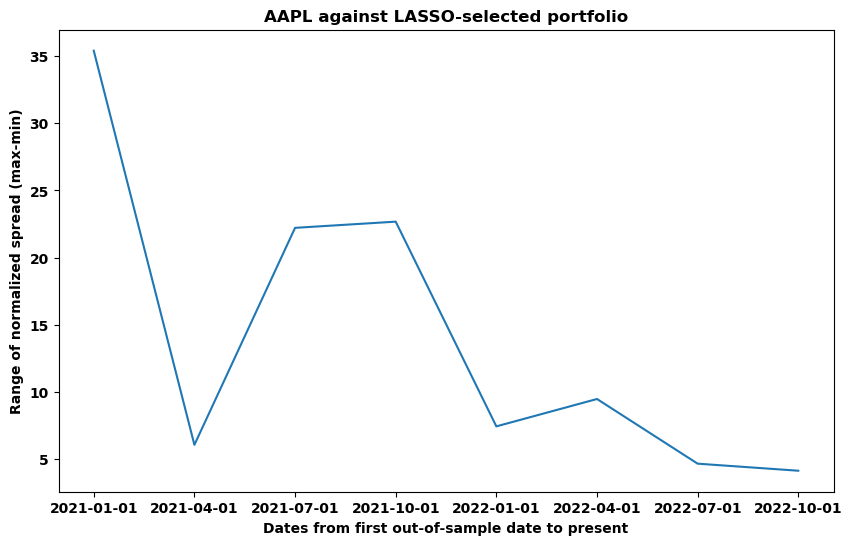

In [11]:
spread_range_oos_to_now = df_spread_norm.describe().loc['max']-df_spread_norm.describe().loc['min']
plt.figure(figsize=(10,6))
plt.plot(spread_range_oos_to_now)
plt.xlabel('Dates from first out-of-sample date to present')
plt.ylabel('Range of normalized spread (max-min)')
plt.title('AAPL against LASSO-selected portfolio')
plt.show()
plt.close()

In [10]:
for i in range(len(dates_list_oos)-1):
    df_spread_norm['lag '+dates_list_oos[i]] = df_spread_norm[dates_list_oos[i]].shift()
df_spread_norm

2021-01-01  2021-04-01  2021-07-01  2021-10-01  2022-01-01  \
Date                                                                     
2021-01-04   -2.748623         NaN         NaN         NaN         NaN   
2021-01-05   -3.085524         NaN         NaN         NaN         NaN   
2021-01-06   -3.658510         NaN         NaN         NaN         NaN   
2021-01-07   -3.076370         NaN         NaN         NaN         NaN   
2021-01-08   -4.324794         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2022-11-30   22.411368    3.493067   18.065240   16.579448    5.816114   
2022-12-01   22.175726    3.463272   17.890117   16.445400    5.676723   
2022-12-02   22.503276    3.694639   18.147054   16.666509    5.805085   
2022-12-05   22.092778    3.630053   18.019986   16.654179    5.768867   
2022-12-06   21.248516    3.520543   17.340222   16.010500    5.285313   

            2022-04-01  2022-07-01  2022-10-01  lag 2021-01-01  \
Date                                                             
2021-01-04         NaN         NaN         NaN             NaN   
2021-01-05         NaN         NaN         NaN       -2.748623   
2021-01-06         NaN         NaN         NaN       -3.085524   
2021-01-07         NaN         NaN         NaN       -3.658510   
2021-01-08         NaN         NaN         NaN       -3.076370   
...                ...         ...         ...             ...   
2022-11-30    0.481011   -1.291918   -3.016907       21.240815   
2022-12-01    1.282206   -0.370220   -2.243622       22.411368   
2022-12-02    1.740155    0.055802   -1.939920       22.175726   
2022-12-05    1.955494    0.154938   -1.900642       22.503276   
2022-12-06    1.670309   -0.166341   -2.367076       22.092778   

            lag 2021-04-01  lag 2021-07-01  lag 2021-10-01  lag 2022-01-01  \
Date                                                                         
2021-01-04             NaN             NaN             NaN             NaN   
2021-01-05             NaN             NaN             NaN             NaN   
2021-01-06             NaN             NaN             NaN             NaN   
2021-01-07             NaN             NaN             NaN             NaN   
2021-01-08             NaN             NaN             NaN             NaN   
...                    ...             ...             ...             ...   
2022-11-30        3.239738       17.282661       15.917402        5.437110   
2022-12-01        3.493067       18.065240       16.579448        5.816114   
2022-12-02        3.463272       17.890117       16.445400        5.676723   
2022-12-05        3.694639       18.147054       16.666509        5.805085   
2022-12-06        3.630053       18.019986       16.654179        5.768867   

            lag 2022-04-01  lag 2022-07-01  lag 2022-10-01  
Date                                                        
2021-01-04             NaN             NaN             NaN  
2021-01-05             NaN             NaN             NaN  
2021-01-06             NaN             NaN             NaN  
2021-01-07             NaN             NaN             NaN  
2021-01-08             NaN             NaN             NaN  
...                    ...             ...             ...  
2022-11-30        0.295395       -1.718711       -3.479100  
2022-12-01        0.481011       -1.291918       -3.016907  
2022-12-02        1.282206       -0.370220       -2.243622  
2022-12-05        1.740155        0.055802       -1.939920  
2022-12-06        1.955494        0.154938       -1.900642  

[424 rows x 16 columns]

In [11]:
# tickers
# beta_list
# train_spread_std_list
# train_normalized_spread_ceil_list

date_action_list = []
for i in range(len(dates_list_oos)-1):
    
    temp_df = df_spread_norm[['lag '+dates_list_oos[i], dates_list_oos[i]]]
    temp_df = temp_df.dropna(axis=0)
    
    should_i_trade = True
    if date_action_list: #if date_action_list is not empty
        
        #check if most recent action already exceeds the start date of this OoS sample, 
        #if so we need to start at later time to avoid excess leverage
        most_recent_action_date = date_action_list[len(date_action_list)-1][0]
        most_recent_action_type = date_action_list[len(date_action_list)-1][1]
        
        if most_recent_action_type == 0:
            #most recent reversion occurs after start of OoS date range, so take no new action till that date
            if most_recent_action_date > temp_df.index[0]: 
                while most_recent_action_date != temp_df.index[0]:
                    temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)
        
        #that means that we have taken a previous position and haven't closed it due to lack of signal, 
        #so do not make any new trades
        if most_recent_action_type != 0:
            should_i_trade = False
    
    reverted_status = True
    while len(temp_df!=0) and should_i_trade: #we will examine each temp_df row-by-row
        
        if reverted_status == True: #if we are not trading already
            
            #explore adding new position only if OoS sample is within 3 months, otherwise we move on to next 3-month OLS model
            if temp_df.index[0] < pd.Timestamp(dates_list_oos[i+1]):
            
                first_spread = temp_df.iat[(0,1)]
                #if absolute value >1 stdev for OoS spread and less than max observed norm spread from training, 
                #record date and entry position
                if np.abs(first_spread) > 1 and \
                np.abs(first_spread) < max(train_normalized_spread_ceil_list[:i+1]): 
                    date_action_list.append( (temp_df.index[0], np.sign(first_spread)) )
                    reverted_status = False
            
        else: #we are in a pairs-trade position, and need to check if it's time to close position
            
            compare_row = temp_df.iloc[0].tolist()

            if temp_df.index[0] < pd.Timestamp(dates_list_oos[i+1]): #check if position is open before next OoS period
            
                #if exceed max(train_normalized_spread_ceil_list) upto time t/i standard deviations on normalized spread, 
                #exit (book major loss)
                if np.abs(compare_row[0]) > max(train_normalized_spread_ceil_list[:i+1]): 
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
                    temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)
                    continue #i.e. skip to start of while loop

                #this only happens if the prev/current spread sign changes, i.e. -/+ or +/-
                if sum(np.sign(compare_row)) == 0:
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
            
            else: #position is open after next OoS period has started
                
                #exit position to book loss if normalized spread exceeds max(train_normalized_spread_ceil_list) upto time t/i
                if np.abs(compare_row[0]) > max(train_normalized_spread_ceil_list[:i+1]): 
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
                    temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)
                    continue #i.e. skip to start of while loop
                
                #exit position if absolute normalized spread is within 0.25
                if np.abs(compare_row[0]) < 0.25: 
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
            
        temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)

In [12]:
np.ceil(len(date_action_list)/2)

11.0

In [13]:
np.floor(len(date_action_list)/2)

10.0

In [14]:
date_action_list

[(Timestamp('2021-01-05 00:00:00'), -1.0),
 (Timestamp('2021-02-18 00:00:00'), 0),
 (Timestamp('2021-02-24 00:00:00'), -1.0),
 (Timestamp('2021-02-26 00:00:00'), 0),
 (Timestamp('2021-03-02 00:00:00'), -1.0),
 (Timestamp('2021-05-10 00:00:00'), 0),
 (Timestamp('2021-07-09 00:00:00'), 1.0),
 (Timestamp('2021-12-01 00:00:00'), 0),
 (Timestamp('2021-12-01 00:00:00'), 1.0),
 (Timestamp('2021-12-10 00:00:00'), 0),
 (Timestamp('2021-12-13 00:00:00'), 1.0),
 (Timestamp('2021-12-15 00:00:00'), 0),
 (Timestamp('2022-01-05 00:00:00'), 1.0),
 (Timestamp('2022-02-09 00:00:00'), 0),
 (Timestamp('2022-03-11 00:00:00'), 1.0),
 (Timestamp('2022-03-22 00:00:00'), 0),
 (Timestamp('2022-04-07 00:00:00'), -1.0),
 (Timestamp('2022-08-01 00:00:00'), 0),
 (Timestamp('2022-08-03 00:00:00'), 1.0),
 (Timestamp('2022-11-04 00:00:00'), 0),
 (Timestamp('2022-11-04 00:00:00'), -1.0)]

A lot of trading actions take place, and this time based on what we saw from the plots earlier, we can expect some heavy losses as well. In total, 11 positions were taken, with 10 positions closed and one still open at the end of the time period.

In [15]:
action_dates, action_type = zip(*date_action_list)
action_dates = [str(i)[:10] for i in action_dates]

In [16]:
df_execution_days = pd.concat([df_oos[['AAPL']],weighted_stock_ooS_models],axis=1)
df_execution_days = df_execution_days.shift(-1).loc[action_dates] #shift up because we act on next day's price
df_execution_days['action type'] = action_type

df_execution_days['AAPL ownership'] = (df_execution_days['action type']*-100) / df_execution_days['AAPL']

df_execution_days['Portfolio ownership'] = np.nan
res_list = []
for i in range(len(dates_list_oos)-1):
     
    df_execution_days_temp = df_execution_days[dates_list_oos[i]:dates_list_oos[i+1]]
    
    if not df_execution_days_temp.empty:
        df_execution_days_temp['Portfolio ownership'] = (df_execution_days_temp['action type']*100) / df_execution_days_temp[dates_list_oos[i]]
        res_list.append(df_execution_days_temp['Portfolio ownership'].values.tolist())
flat_list = [item for sublist in res_list for item in sublist]
df_execution_days['Portfolio ownership'] = flat_list

df_execution_days['AAPL ownership shift'] = df_execution_days['AAPL ownership'].shift()
df_execution_days['Portfolio ownership shift'] = df_execution_days['Portfolio ownership'].shift()
arb_ret_list = []
for i in range(len(dates_list_oos)-1):
     
    df_execution_days_temp = df_execution_days[dates_list_oos[i]:dates_list_oos[i+1]]
    
    if not df_execution_days_temp.empty:
        df_execution_days_temp['arbitrage returns'] = \
        df_execution_days_temp['AAPL']*df_execution_days_temp['AAPL ownership shift'] + \
        df_execution_days_temp[dates_list_oos[i]]*df_execution_days_temp['Portfolio ownership shift'] 
        arb_ret_list.append(df_execution_days_temp['arbitrage returns'].values.tolist())
arb_ret_flat_list = [item for sublist in arb_ret_list for item in sublist]
df_execution_days['arbitrage returns'] = arb_ret_flat_list

df_execution_days

AAPL  2021-01-01  2021-04-01  2021-07-01  2021-10-01  \
Date                                                                     
2021-01-05  126.599998  138.569208         NaN         NaN         NaN   
2021-02-18  129.869995  153.148806         NaN         NaN         NaN   
2021-02-24  120.989998  143.687621         NaN         NaN         NaN   
2021-02-26  125.120003  140.803884         NaN         NaN         NaN   
2021-03-02  122.059998  140.855886         NaN         NaN         NaN   
2021-05-10  125.910004  129.297110  129.313403         NaN         NaN   
2021-07-09  144.500000  141.180917  126.541719  138.162368         NaN   
2021-12-01  163.759995  139.701627  119.335341  145.088110  155.188982   
2021-12-01  163.759995  139.701627  119.335341  145.088110  155.188982   
2021-12-10  175.740005  142.561684  121.183131  147.163273  156.819599   
2021-12-13  174.330002  138.128309  121.552688  141.303273  149.523623   
2021-12-15  172.259995  130.375797  123.030920  134.339115  143.003210   
2022-01-05  172.000000  119.067848  121.367910  122.629418  131.188503   
2022-02-09  172.119995  118.814126  118.596226  118.463846  127.741639   
2022-03-11  150.619995   95.593687  108.987722   98.638112  106.483063   
2022-03-22  170.210007  100.298231  109.542059  103.632601  111.449302   
2022-04-07  170.089996  100.462524  104.553028  106.154983  115.515303   
2022-08-01  160.009995   92.401536   93.281514   95.882727  105.953012   
2022-08-03  165.809998   95.260439   92.911956   99.080101  109.131104   
2022-11-04  138.919998   68.198206   90.509830   68.675156   77.129151   
2022-11-04  138.919998   68.198206   90.509830   68.675156   77.129151   

            2022-01-01  2022-04-01  2022-07-01  2022-10-01  action type  \
Date                                                                      
2021-01-05         NaN         NaN         NaN         NaN         -1.0   
2021-02-18         NaN         NaN         NaN         NaN          0.0   
2021-02-24         NaN         NaN         NaN         NaN         -1.0   
2021-02-26         NaN         NaN         NaN         NaN          0.0   
2021-03-02         NaN         NaN         NaN         NaN         -1.0   
2021-05-10         NaN         NaN         NaN         NaN          0.0   
2021-07-09         NaN         NaN         NaN         NaN          1.0   
2021-12-01         NaN         NaN         NaN         NaN          0.0   
2021-12-01         NaN         NaN         NaN         NaN          1.0   
2021-12-10         NaN         NaN         NaN         NaN          0.0   
2021-12-13         NaN         NaN         NaN         NaN          1.0   
2021-12-15         NaN         NaN         NaN         NaN          0.0   
2022-01-05  149.063541         NaN         NaN         NaN          1.0   
2022-02-09  139.621048         NaN         NaN         NaN          0.0   
2022-03-11  122.494549         NaN         NaN         NaN          1.0   
2022-03-22  128.876956         NaN         NaN         NaN          0.0   
2022-04-07  135.196668  173.748679         NaN         NaN         -1.0   
2022-08-01  128.641041  161.291404  155.462276         NaN          0.0   
2022-08-03  131.462941  164.766787  156.736093         NaN          1.0   
2022-11-04  101.945482  126.736401  142.114205  151.105783          0.0   
2022-11-04  101.945482  126.736401  142.114205  151.105783         -1.0   

            AAPL ownership  Portfolio ownership  AAPL ownership shift  \
Date                                                                    
2021-01-05        0.789889            -0.721661                   NaN   
2021-02-18       -0.000000             0.000000              0.789889   
2021-02-24        0.826515            -0.695954             -0.000000   
2021-02-26       -0.000000             0.000000              0.826515   
2021-03-02        0.819269            -0.709945             -0.000000   
2021-05-10       -0.000000             0.000000              0.819269   
2021-

In [18]:
#returns if negative values/losses are excluded
df_execution_days[df_execution_days['arbitrage returns']>0][['arbitrage returns']].sum()

arbitrage returns    33.992671
dtype: float64

In [19]:
#true return
df_execution_days['arbitrage returns'].sum()

1.4105489521795107

In [17]:
df_execution_days[['arbitrage returns']].iloc[1::2].describe()

arbitrage returns
count          10.000000
mean            0.141055
std             7.843300
min            -7.938592
25%            -6.369445
50%            -2.089237
75%             5.214932
max            12.625134

On a $100 long/short into AAPL or Portfolio at an appropriate time, based on predictions from our LASSO model, our results reveal that this strategy returns a worse performance than simple pairs trade, the maximum loss was huge (in the few cases when model failed to model the deviation in spread accurately), and the number of trades made were more compared to simple pairs trading. LASSO regression is likely not appropriate against AAPL, as multiple stocks in the model tend to smooth the training period deviation while not being robust to out-of-sample spread deviation modelling, despite the sparsity offered by the L1-norm regularizer of LASSO regression. We noticed some spurious stocks being selected by the LASSO model like the Chinese liquor company "600519.SS" or Kweichow Moutai, which likely led to its poor performance. We also noticed that Samsung was present in every model, implying that Samsung might be a fantastic company to run a pairs trade algorithm against AAPL. This shouldn't surprise us as they both are huge in the tablet/laptop/phone markets and are the biggest competitors to each other globally. Thus, we notice that while LASSO regression wasn't particularly helpful, it allowed us to choose the most relevant feature to run a simple pairs trade algorithm, highlighting it's potential for feature selection.

Finally, we do an analysis of the features selected by the LASSO model across each of the eight out-of-sample periods to see which names showed up most often, and if anything meaningful can be drawn from that:

In [20]:
features_selected_flat_list = [item for sublist in features_selected_list for item in sublist]

In [21]:
Counter(features_selected_flat_list)

Counter({'005930.KS': 8,
         '600519.SS': 6,
         'BABA': 2,
         'RMS.PA': 6,
         'ADBE': 6,
         'CDI.PA': 3,
         '3690.HK': 3,
         'TMO': 4,
         'MA': 1,
         'ASML': 1,
         'AVGO': 3,
         'COST': 3,
         'NFLX': 2,
         '300750.SZ': 1})

Of the eight of out-of-sample periods, these were the stocks our LASSO model chose at least half the time:
- 005930.KS/Samsung each time
- 600519.SS/Kweichow Moutai 6/8 times (reject because it's a liquor company and it's correlation seems coincidental)
- RMS.PA/Hermes International 6/8 times (reject because it's a fashion company and it's correlation seems coincidental)
- ADBE/Adobe 6/8 times
- TMO/Thermo Fisher 4/8 times
  
Of the stocks less commonly picked (but picks that still belong in considered a tech/adjacent industries):
- AVGO/Broadcom Inc 3/8 times (semiconductor and infrastructure software company)
- BABA/Alibaba 2/8 times
- NFLX 2/8 times

In [22]:
set(features_selected_flat_list)

{'005930.KS',
 '300750.SZ',
 '3690.HK',
 '600519.SS',
 'ADBE',
 'ASML',
 'AVGO',
 'BABA',
 'CDI.PA',
 'COST',
 'MA',
 'NFLX',
 'RMS.PA',
 'TMO'}

We remove the liquor and fashion companies from this list and then rerun the LASSO regression with only the relevant identified companies here post feature-selection in pairs_trading_AAPL_LASSO_v2_postLASSO_feature_selection.ipynb.